In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Data Preprocessing

In [4]:
train=pd.read_csv('Train_dataset.csv')
train2=pd.read_csv('Train_dataset2.csv')
test = pd.read_csv('Test_dataset.csv')
train=train.dropna()
test = test.dropna()

train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
train2['class']=train2['class'].str[0:-1]
train2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack


### Filtering train and test records by protocol_type column (only TCP/IP protocols)

In [6]:
print(train['protocol_type'].unique())
print(train2['protocol_type'].unique())
print(test['protocol_type'].unique())

['tcp' 'udp' 'icmp']
['udp' 'tcp' 'icmp']
['tcp' 'icmp' 'udp']


In [156]:
train = train[train.protocol_type != 'udp']
train2 = train2[train2.protocol_type != 'udp']
test = test[test.protocol_type != 'udp']
print(train['protocol_type'].unique())
print(train2['protocol_type'].unique())
print(test['protocol_type'].unique())

['tcp' 'icmp']
['tcp' 'icmp']


### Replace value if records is anomalous due to limit class column to two value - normal and anomalous

In [157]:
print(train['class'].unique())

['normal' 'named' 'xlock' 'smurf' 'ipsweep' 'multihop' 'xsnoop' 'sendmail'
 'guess_passwd' 'saint' 'buffer_overflow' 'portsweep' 'pod' 'apache2'
 'phf' 'warezmaster' 'perl' 'satan' 'xterm' 'mscan' 'processtable' 'ps'
 'nmap' 'rootkit' 'neptune' 'loadmodule' 'imap' 'back' 'httptunnel' 'worm'
 'mailbomb' 'ftp_write' 'land' 'sqlattack' 'snmpguess']


In [158]:
train.loc[train['class'] != "normal", 'class'] = "anomalous"
print(train['class'].unique())

['normal' 'anomalous']


In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284326 entries, 9 to 310931
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     284326 non-null  int64  
 1   protocol_type                284326 non-null  object 
 2   service                      284326 non-null  object 
 3   flag                         284326 non-null  object 
 4   src_bytes                    284326 non-null  int64  
 5   dst_bytes                    284326 non-null  int64  
 6   land                         284326 non-null  int64  
 7   wrong_fragment               284326 non-null  int64  
 8   urgent                       284326 non-null  int64  
 9   hot                          284326 non-null  int64  
 10  num_failed_logins            284326 non-null  int64  
 11  logged_in                    284326 non-null  int64  
 12  num_compromised              284326 non-null  int64  
 13 

In [160]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
9,0,tcp,http,SF,223,185,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.00,normal
11,0,tcp,http,SF,230,260,0,0,0,0,...,255,1.00,0.00,0.33,0.07,0.33,0.0,0.00,0.00,normal
14,1,tcp,smtp,SF,3170,329,0,0,0,0,...,39,0.72,0.11,0.02,0.00,0.02,0.0,0.09,0.13,normal
15,0,tcp,http,SF,297,13787,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.00,normal
16,0,tcp,http,SF,291,3542,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.00,normal


In [161]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,284326.000000,2.843260e+05,2.843260e+05,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,...,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000,284326.000000
mean,19.229304,1.886044e+03,8.094752e+02,0.000032,0.000345,0.000056,0.016056,0.002585,0.188674,0.012299,...,234.029318,195.266908,0.777575,0.024894,0.593566,0.004955,0.064264,0.064313,0.155834,0.155001
std,422.980784,1.335158e+05,1.685886e+04,0.005626,0.018562,0.010272,0.326360,0.052279,0.391250,2.048219,...,62.674883,102.873646,0.397908,0.094158,0.485605,0.037256,0.241175,0.242963,0.357244,0.359626
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.720000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,175.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.030000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,1.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [162]:
train.describe(include='object')

,protocol_type,service,flag,class
count,284326,284326,284326,284326
unique,2,62,11,2
top,icmp,ecr_i,SF,anomalous
freq,164969,164352,221676,239830


### Missing Data

In [163]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

### Duplicates

In [164]:
duplicates = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates != 0:
    train=train.drop_duplicates()
    print(f"Number of duplicate rows after removing them: {train.duplicated().sum()}")


Number of duplicate rows: 211732
Number of duplicate rows after removing them: 0


### Outliers

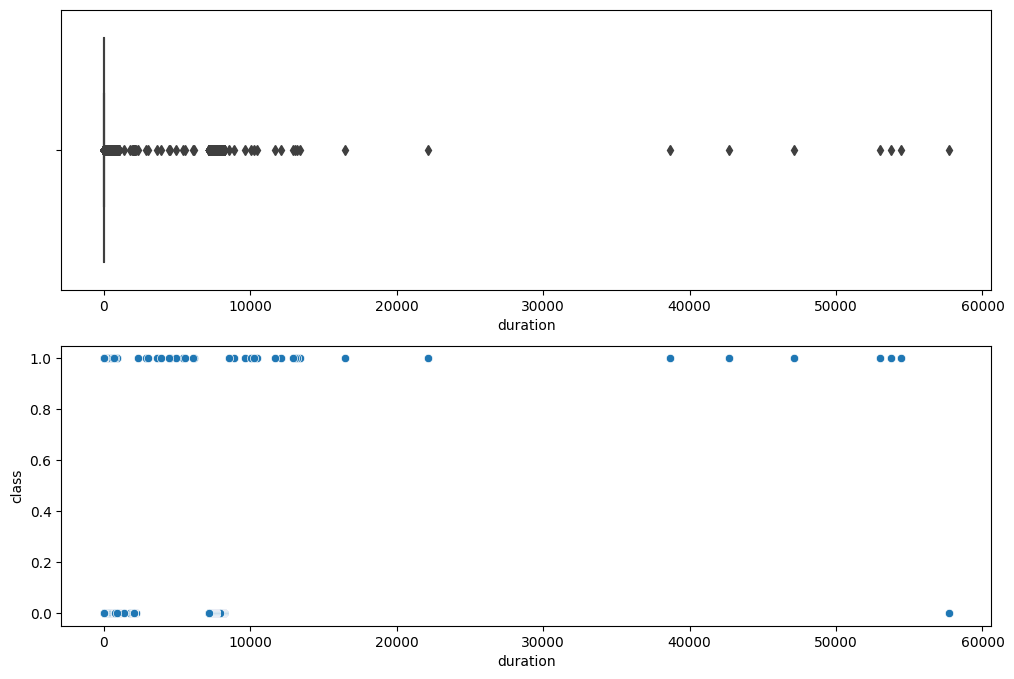

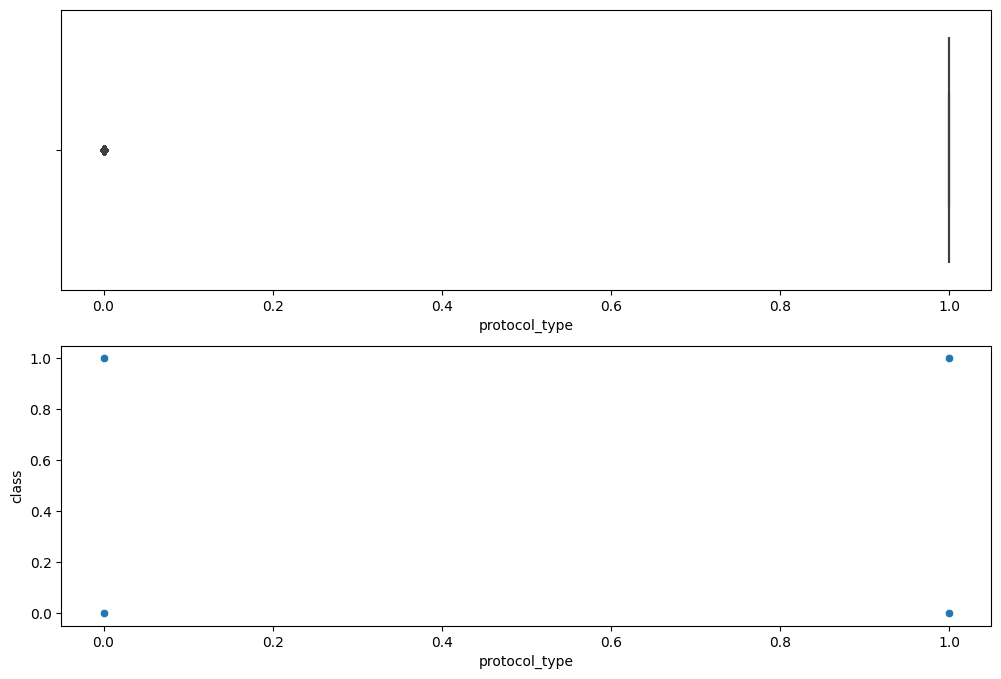

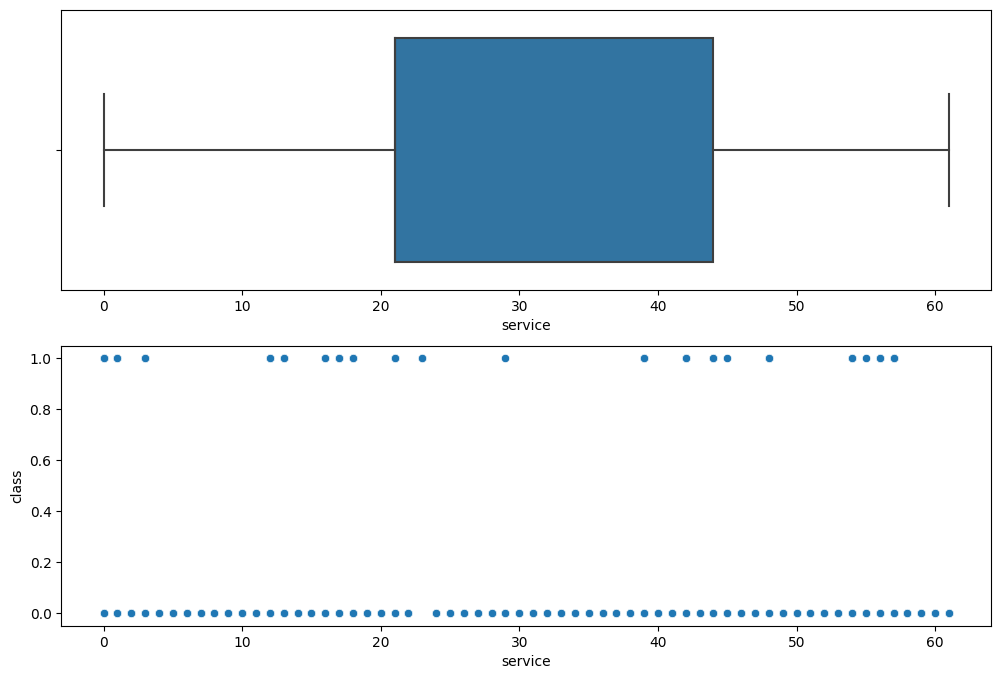

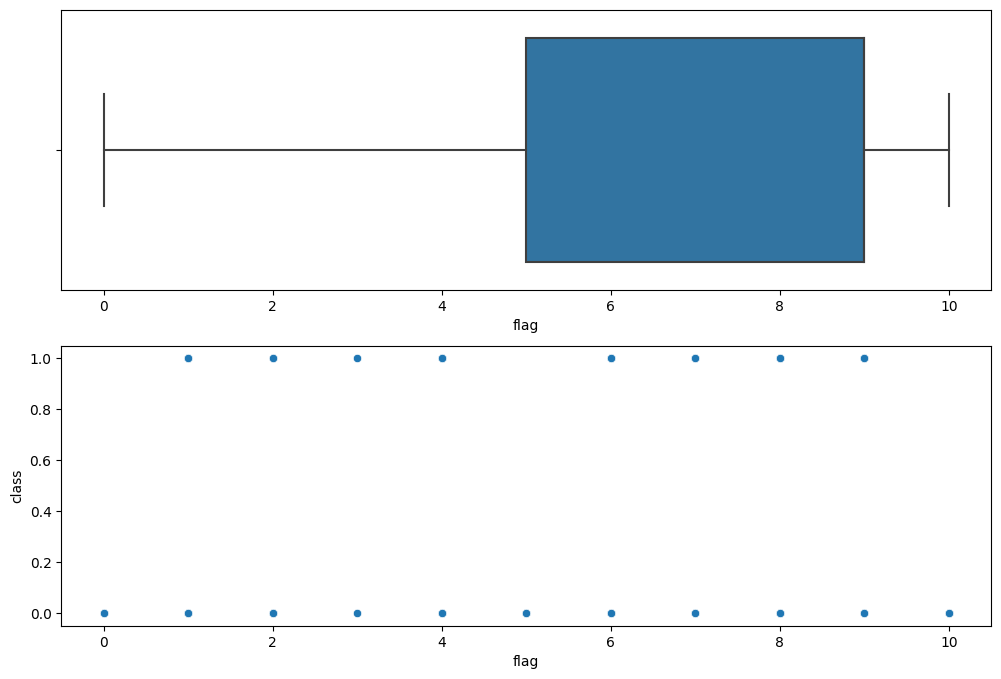

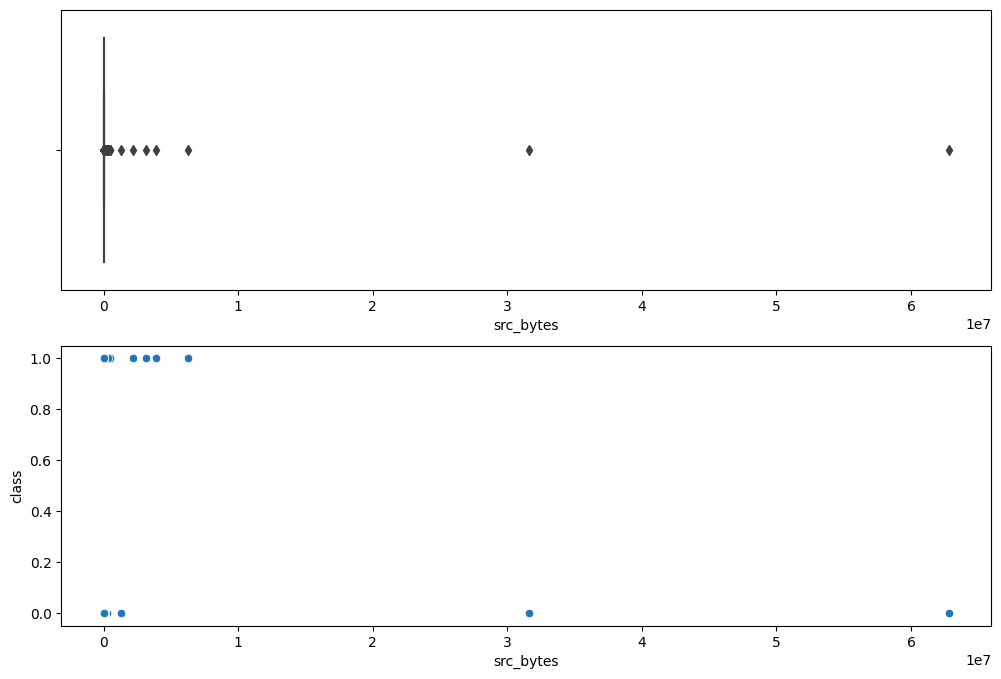

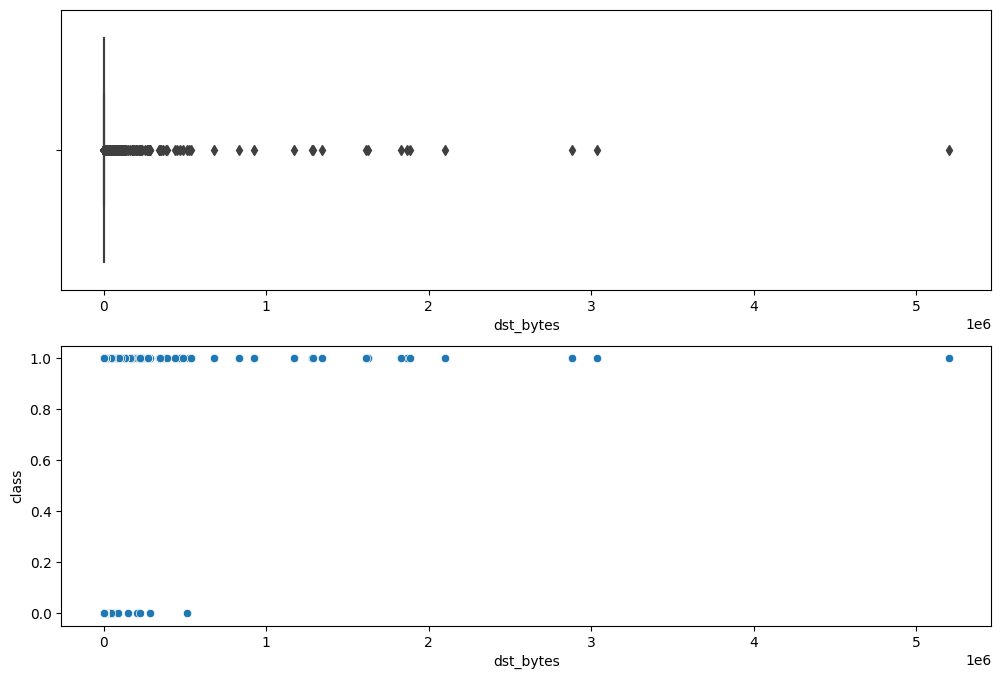

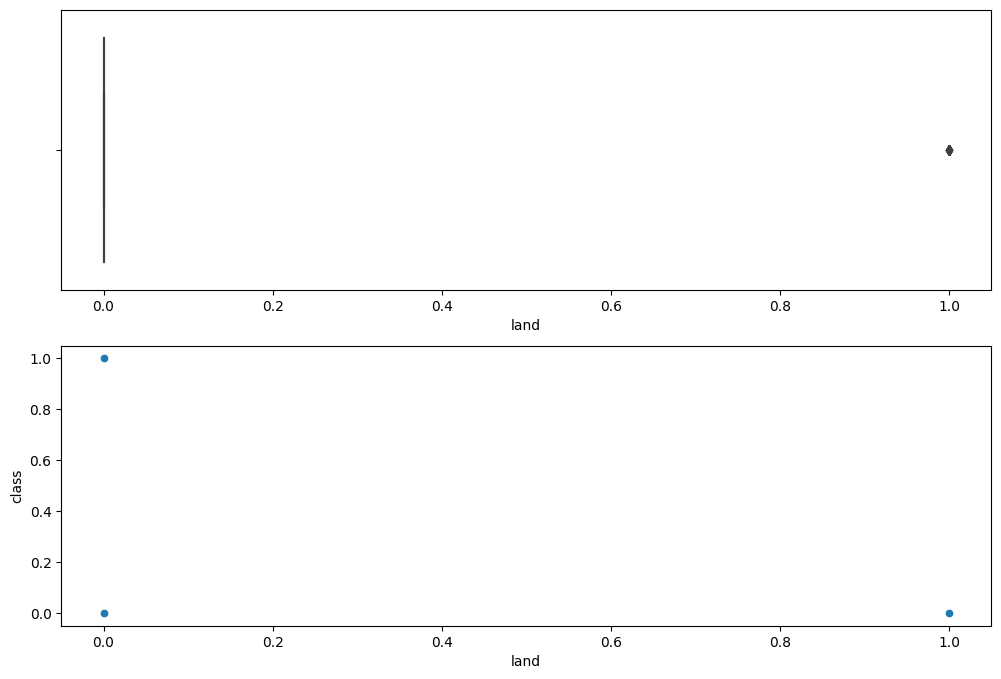

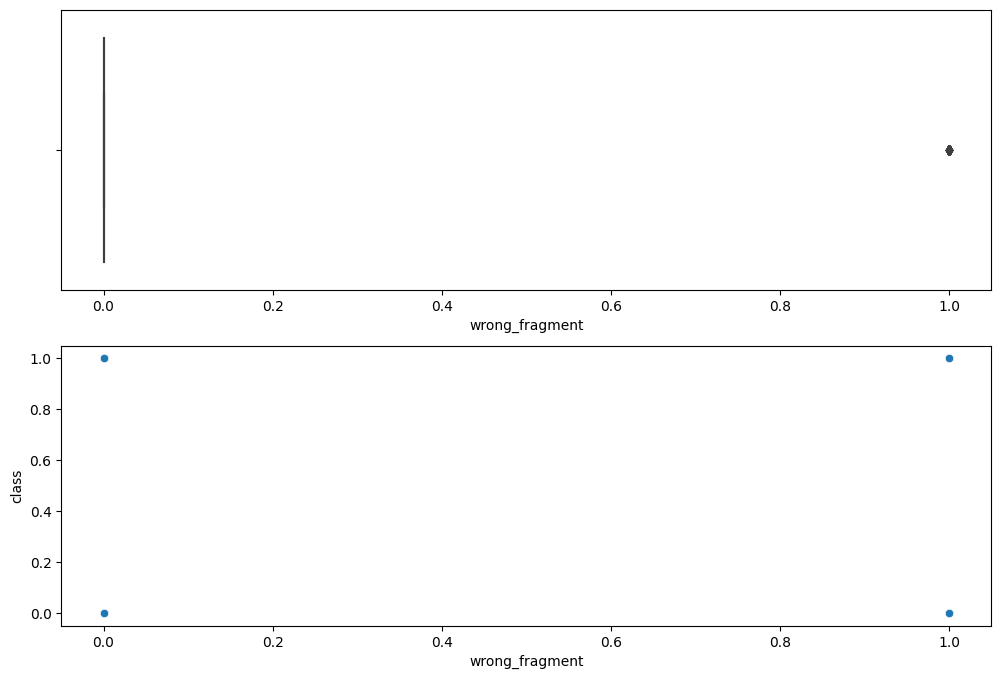

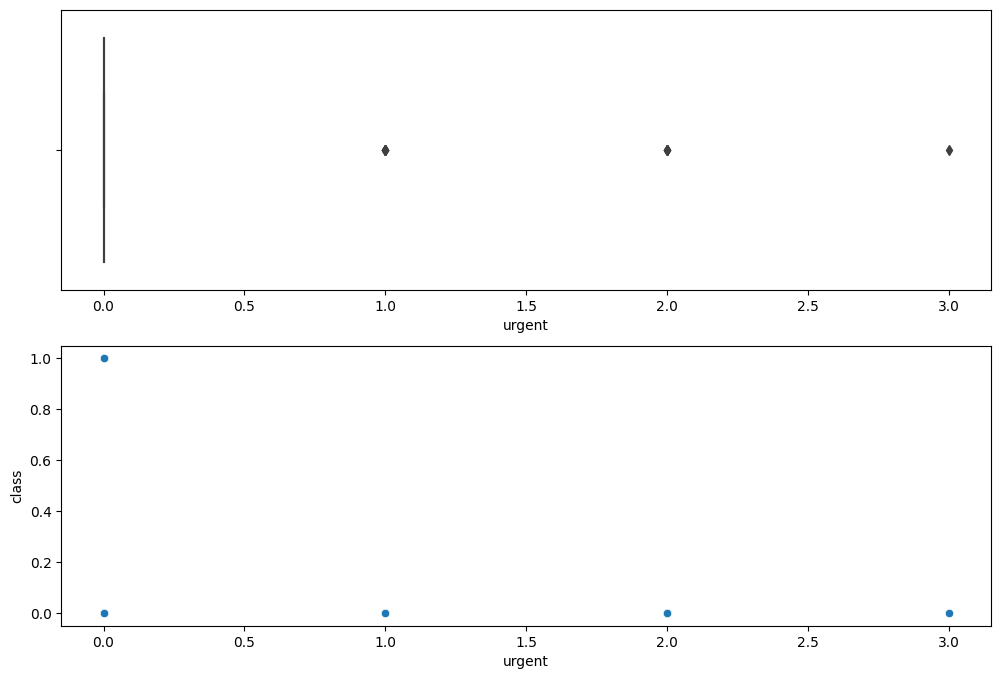

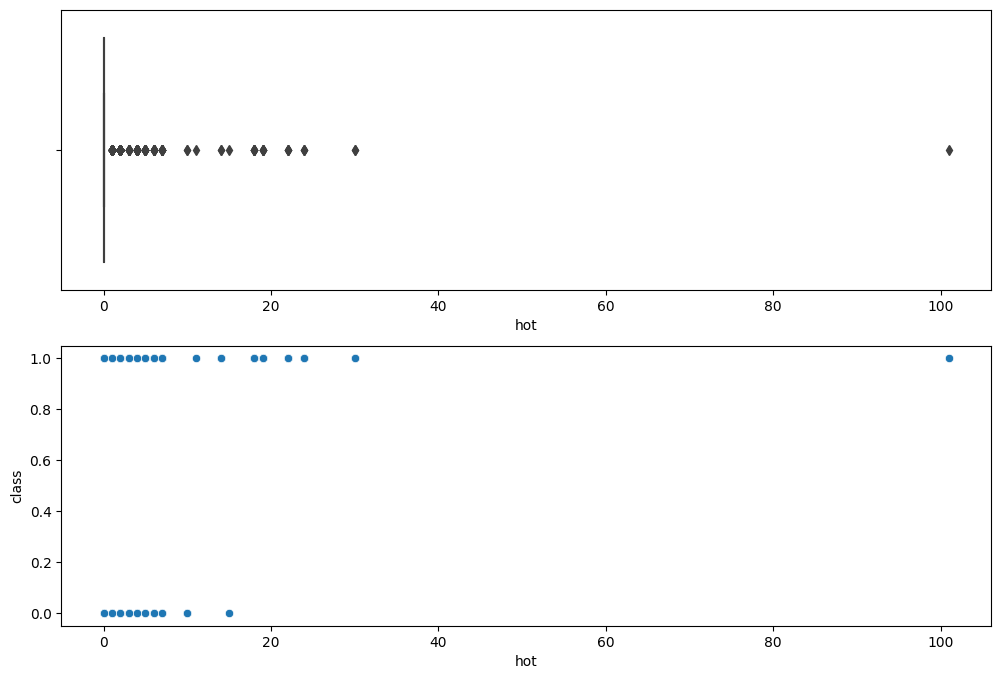

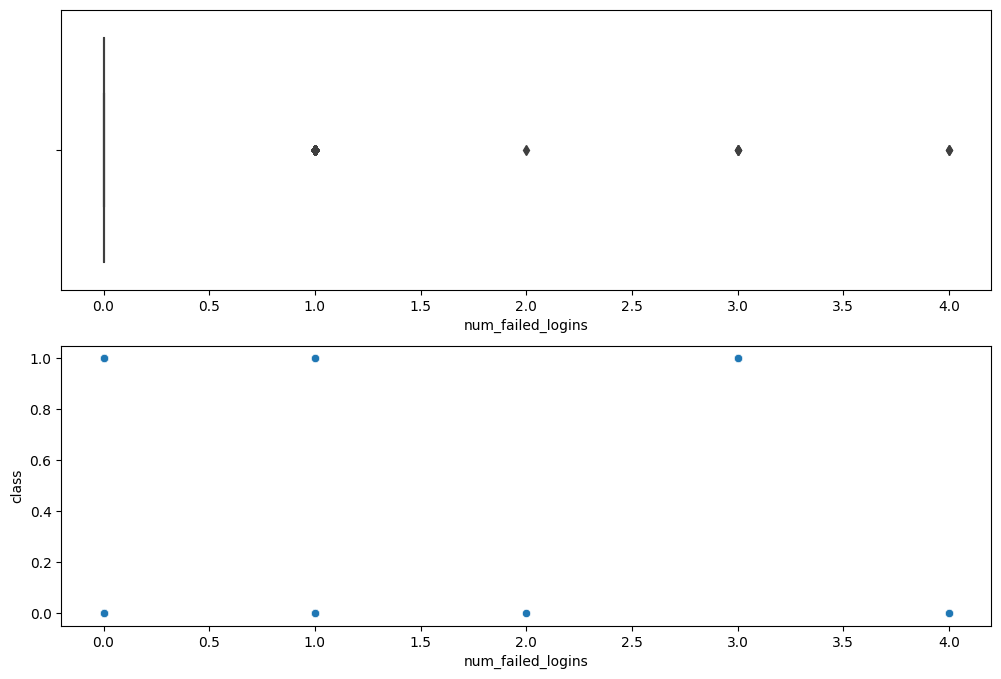

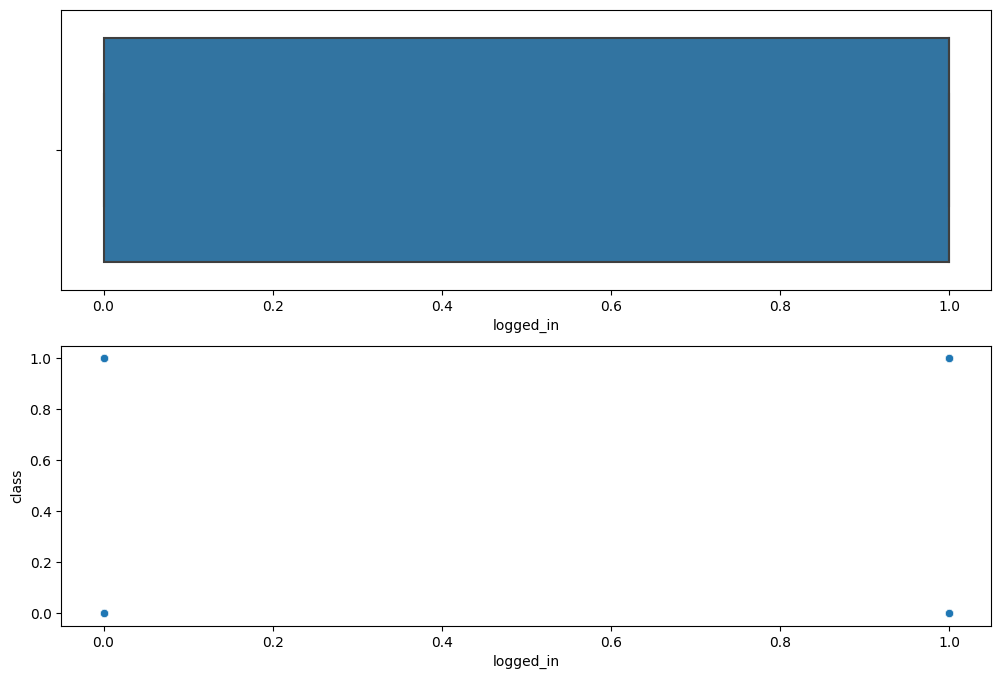

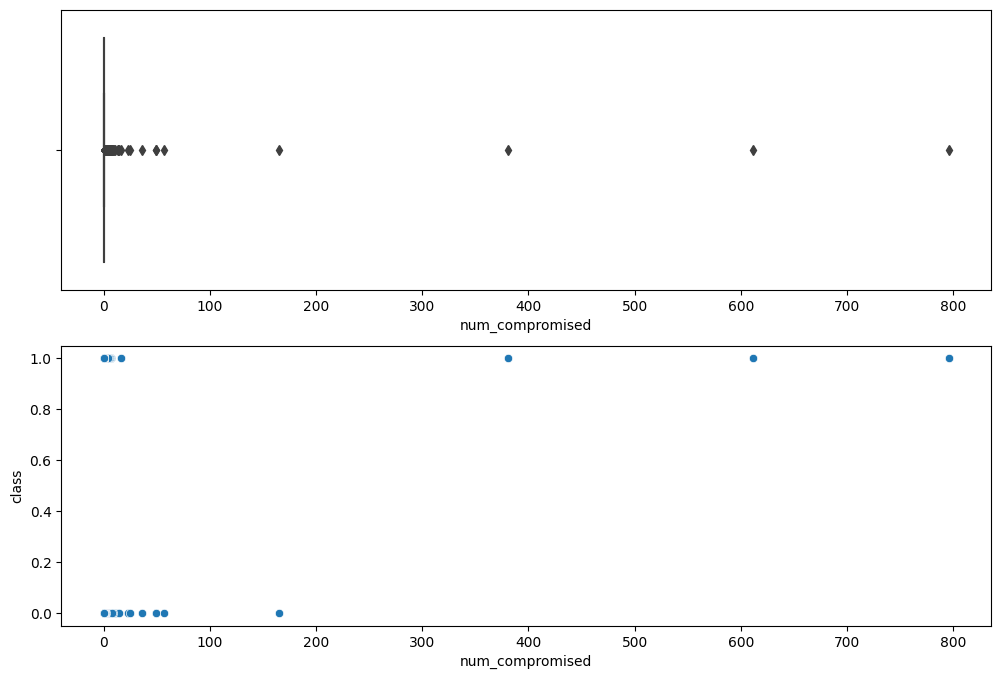

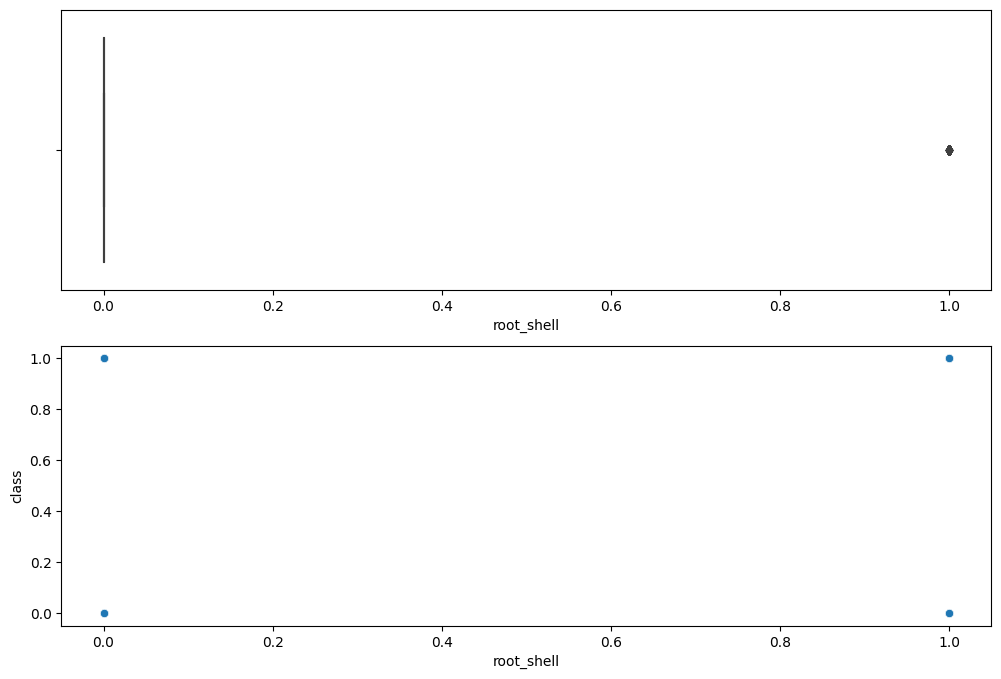

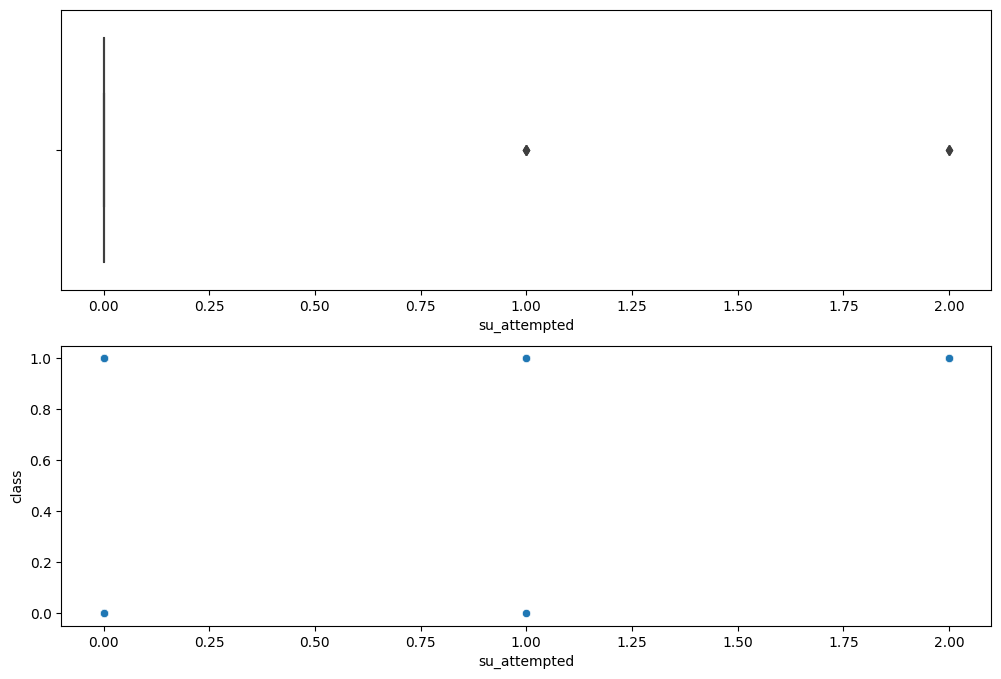

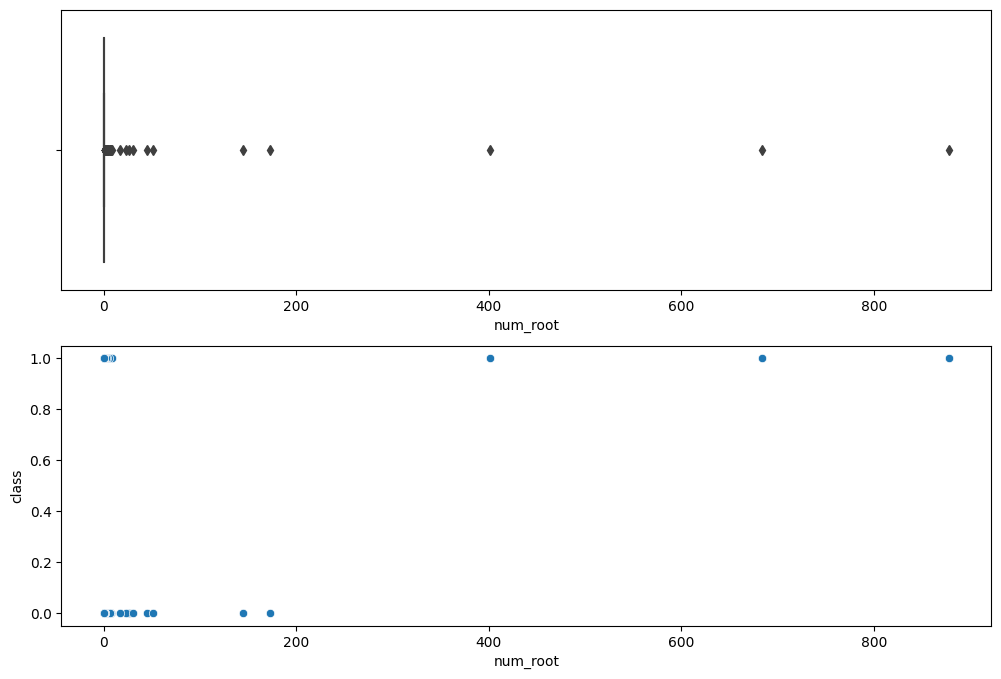

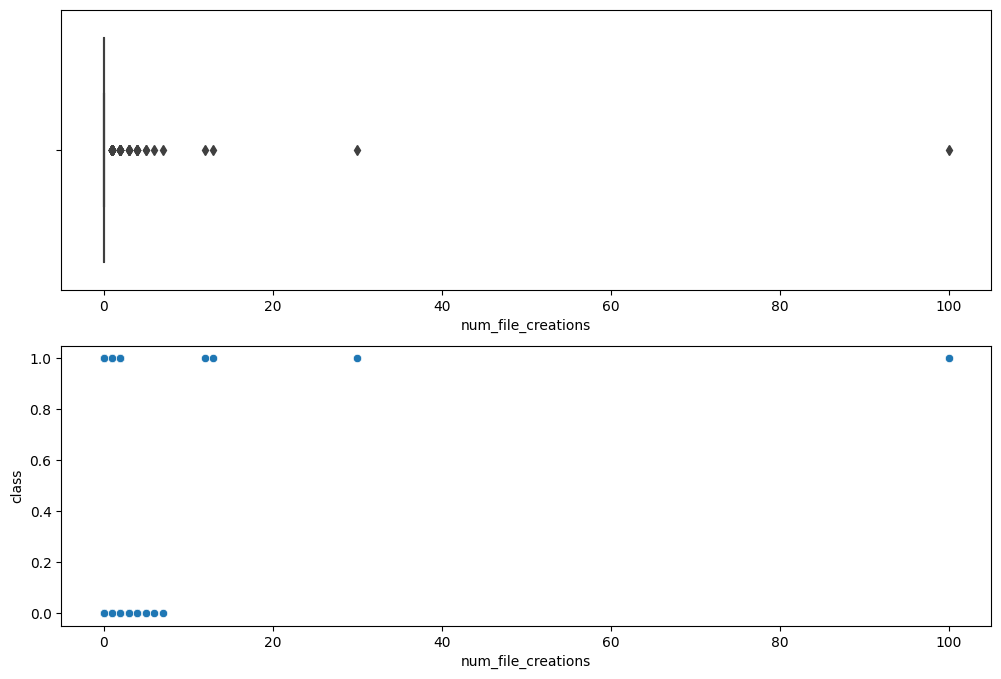

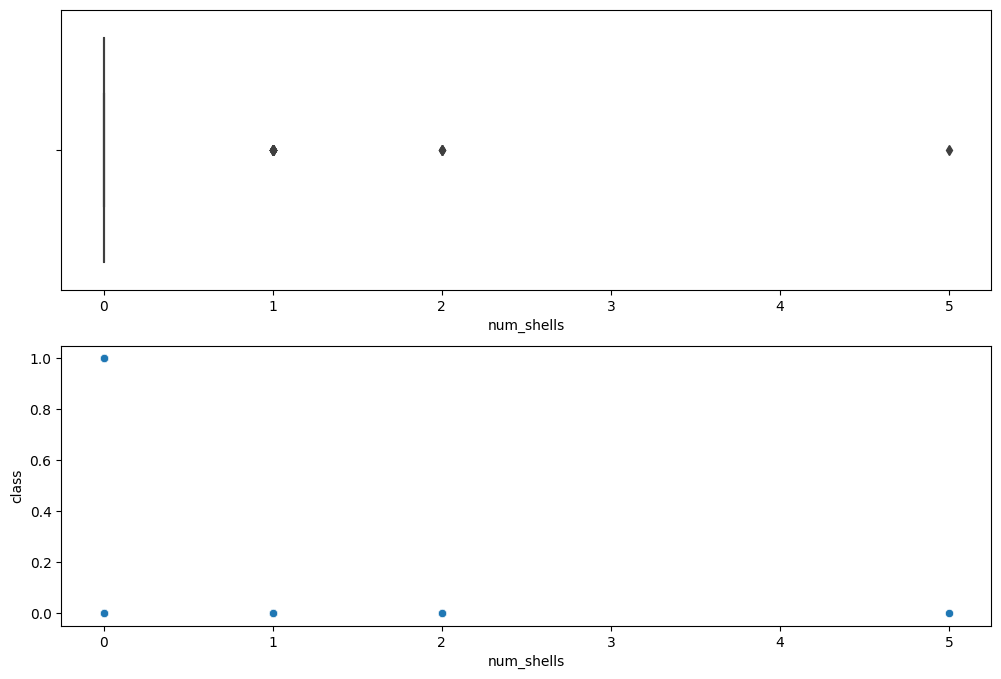

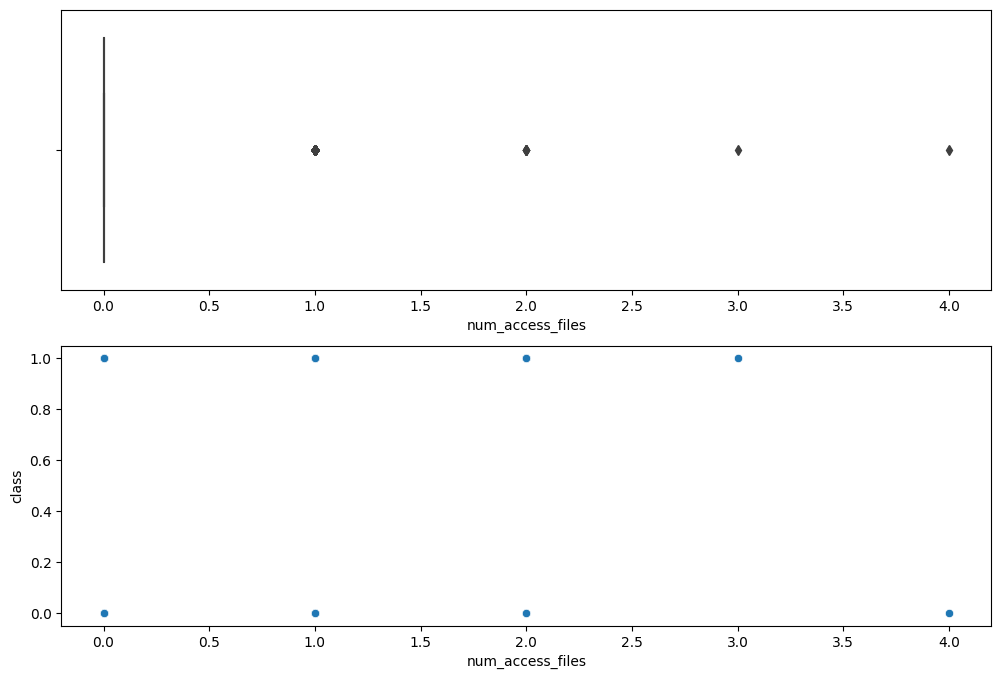

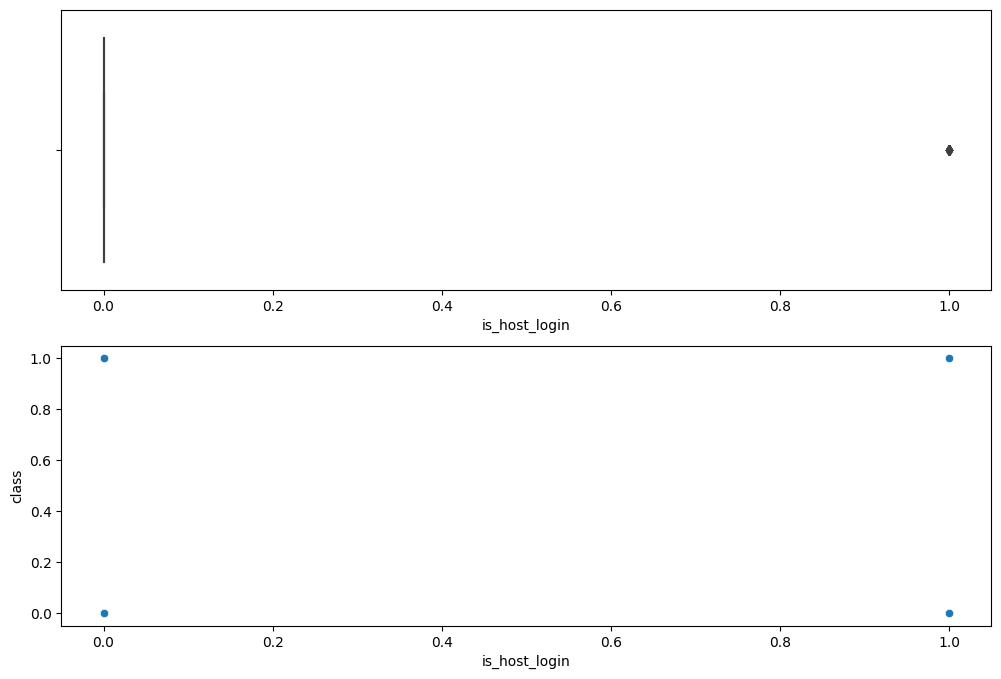

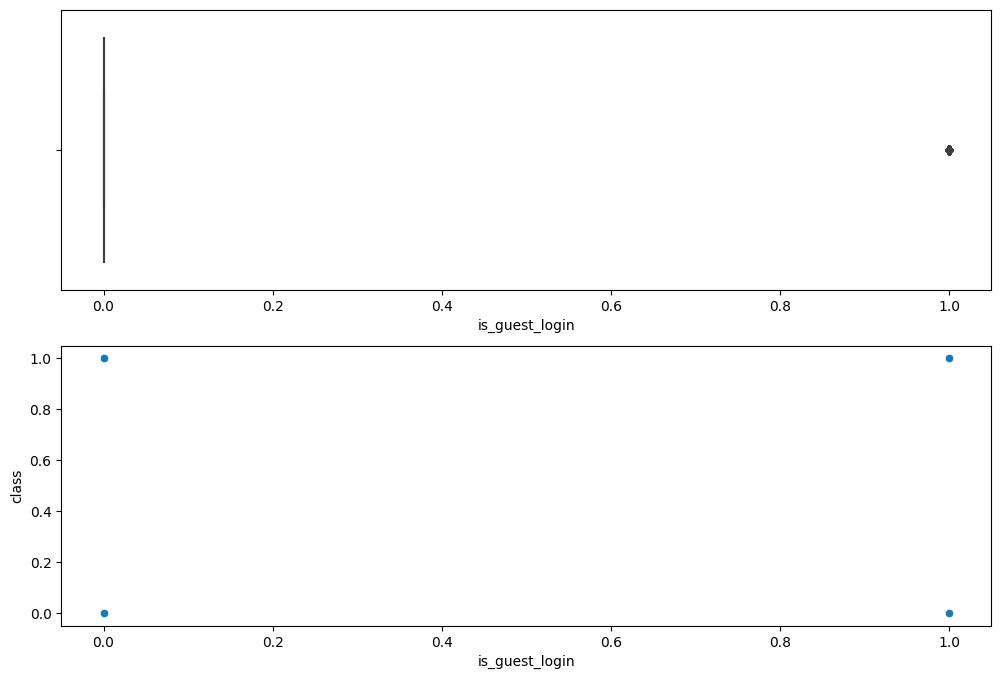

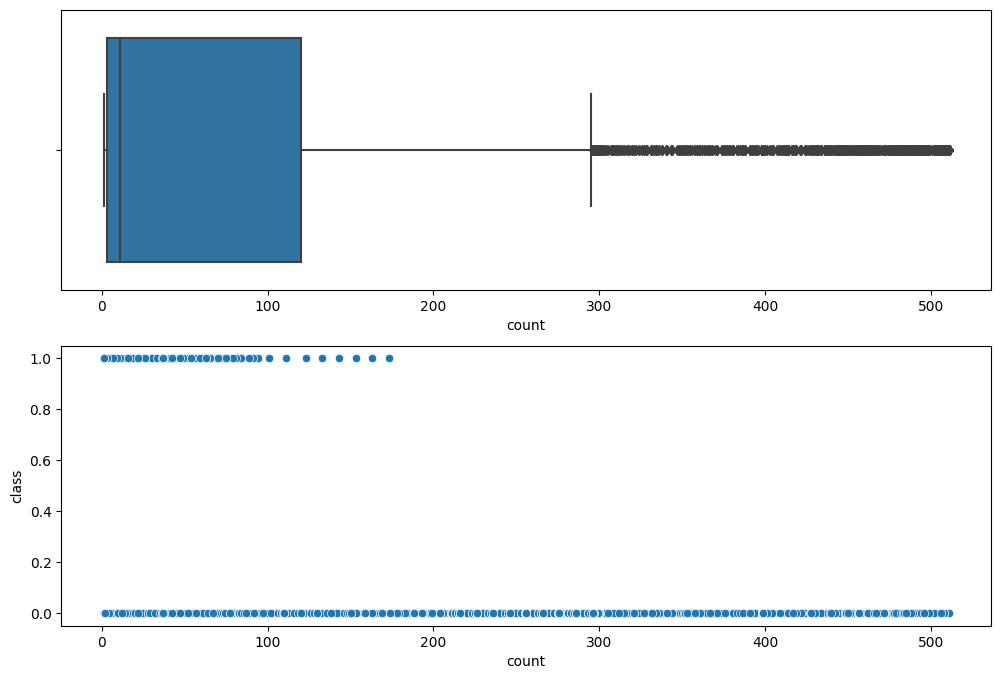

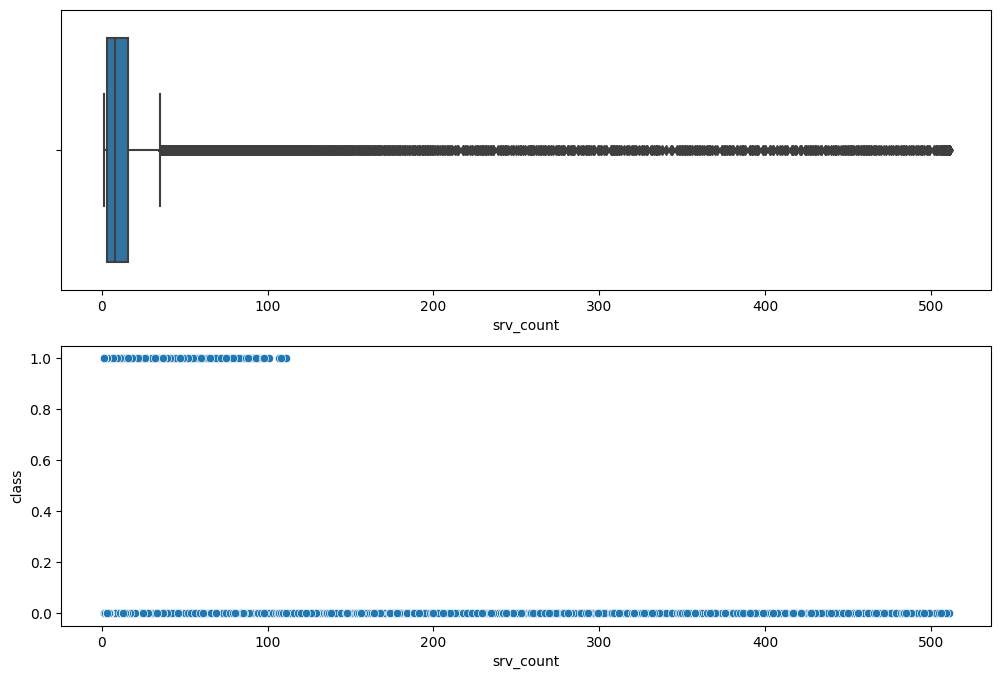

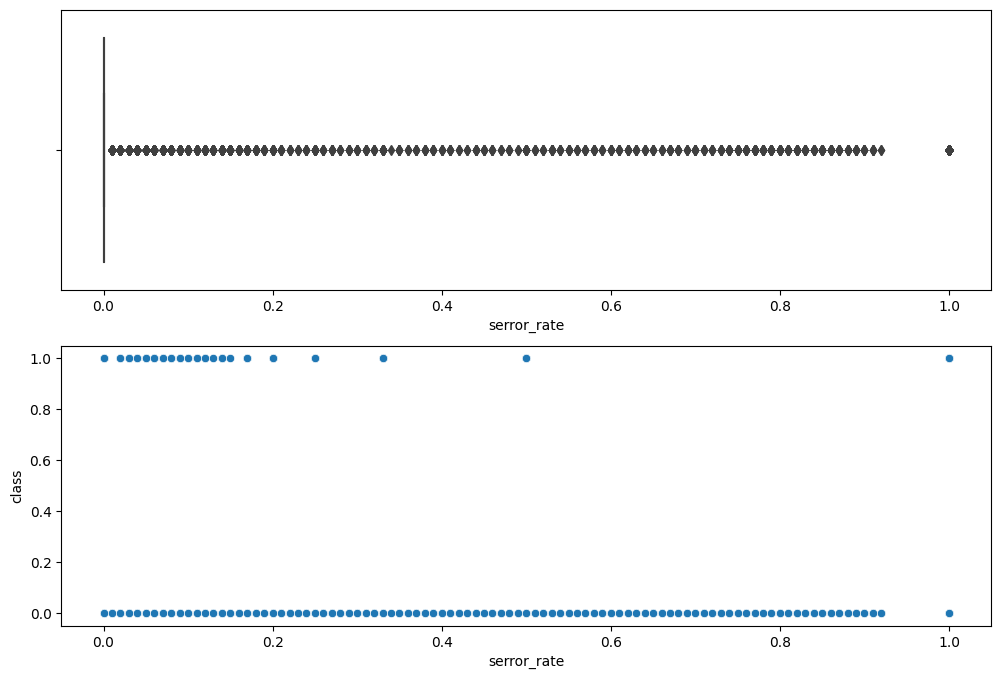

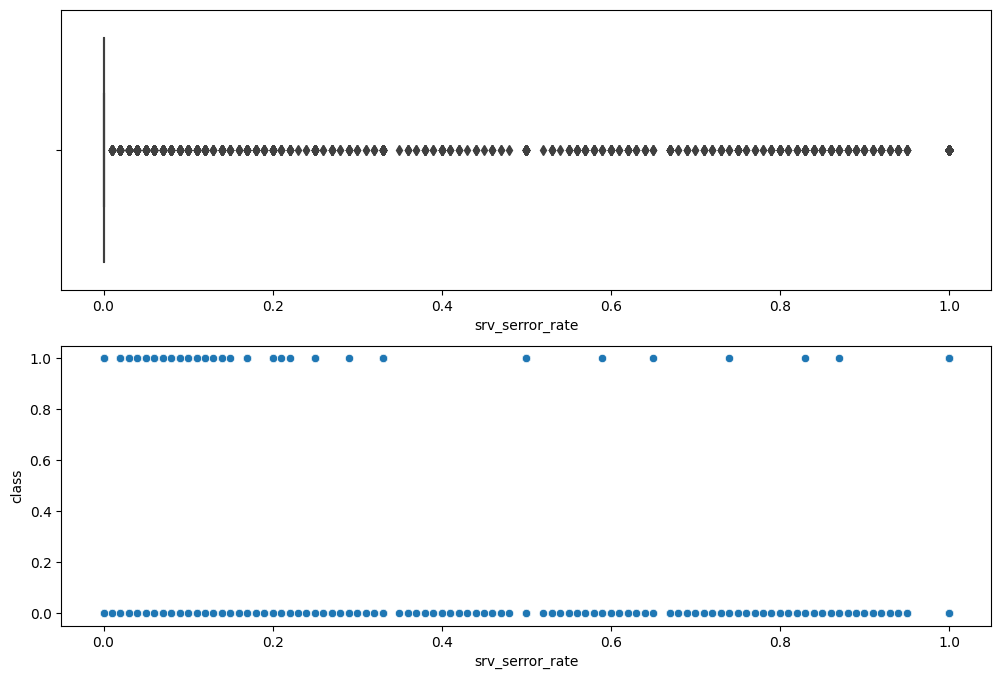

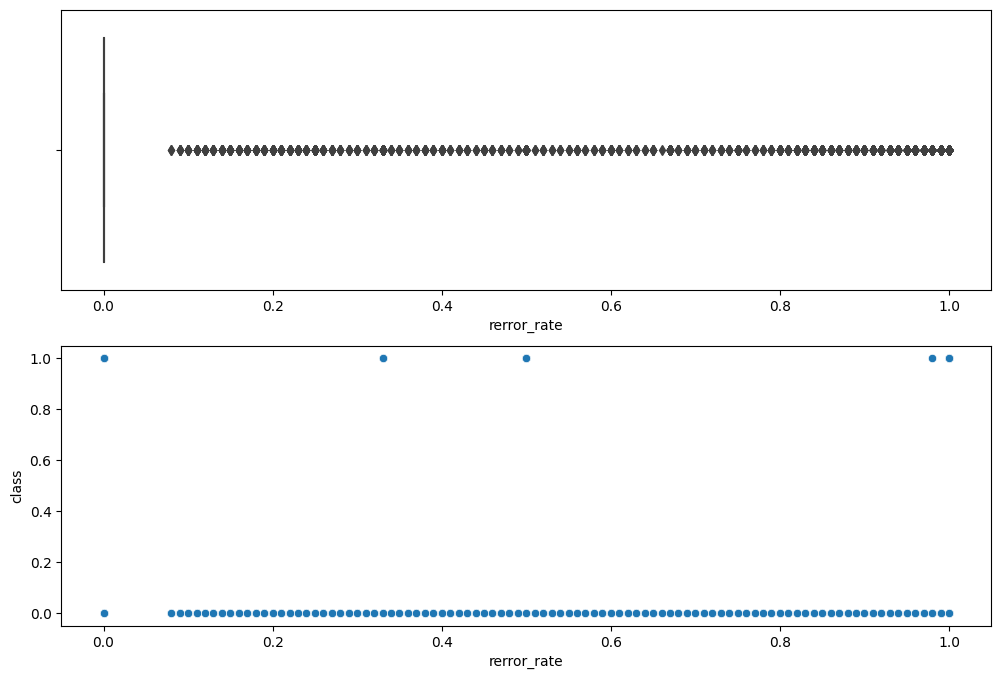

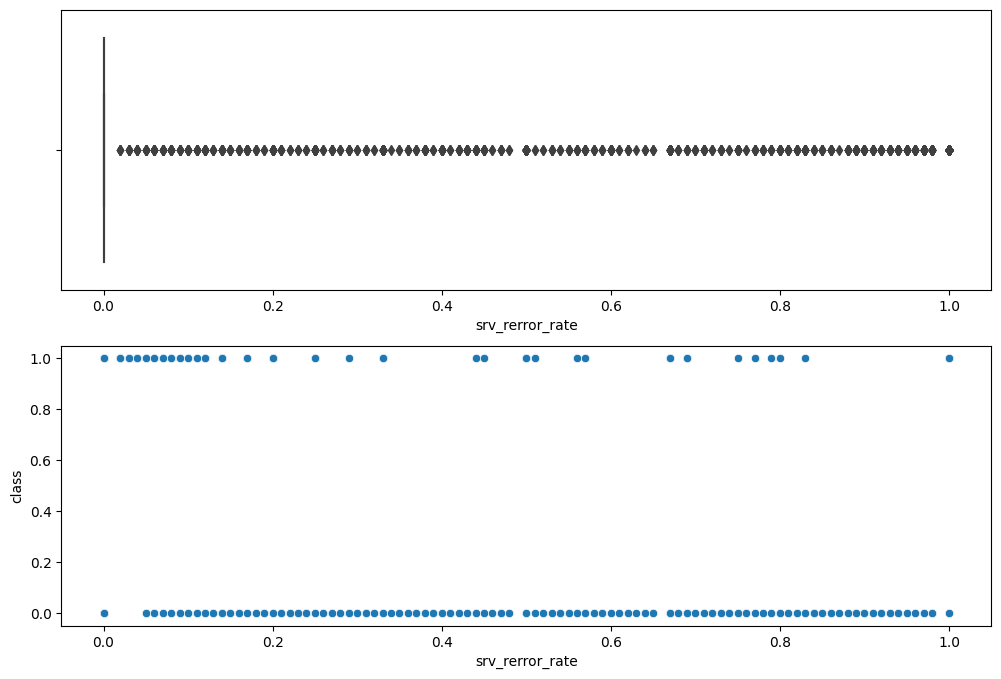

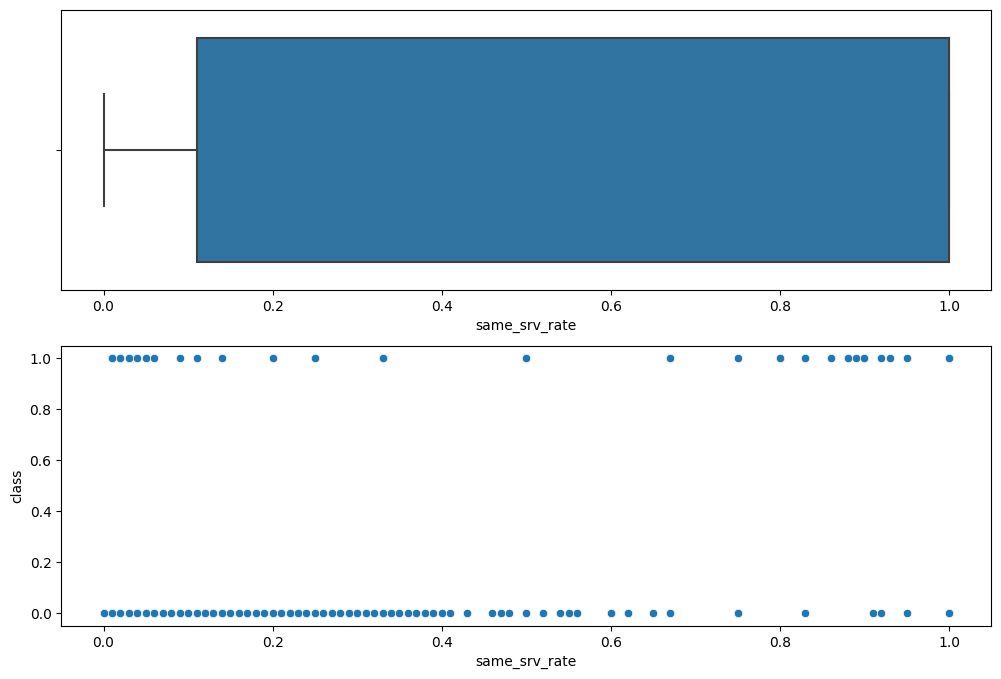

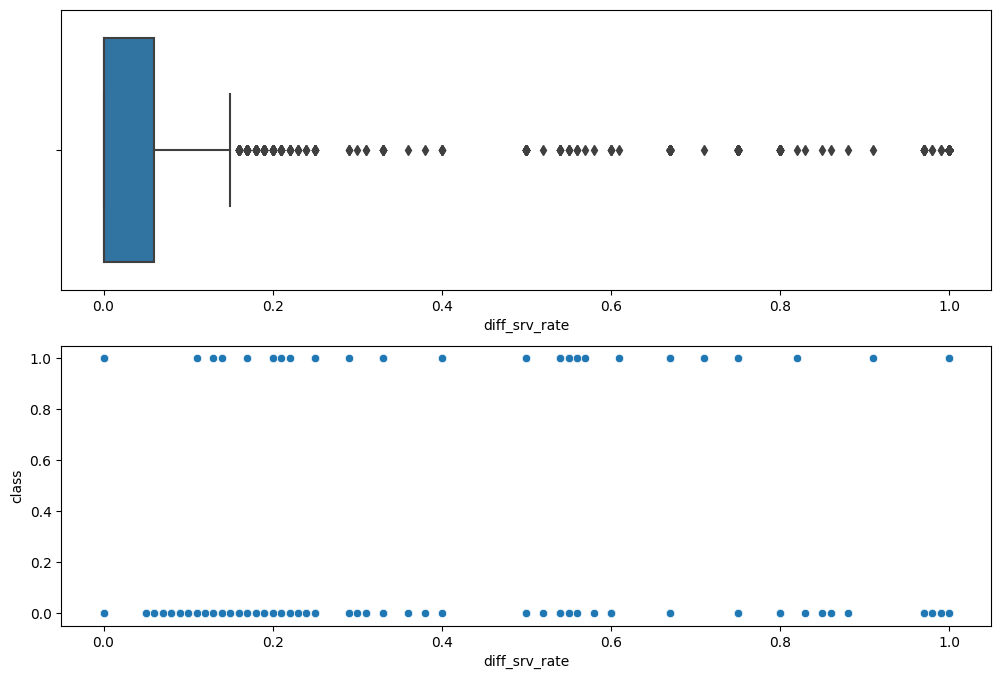

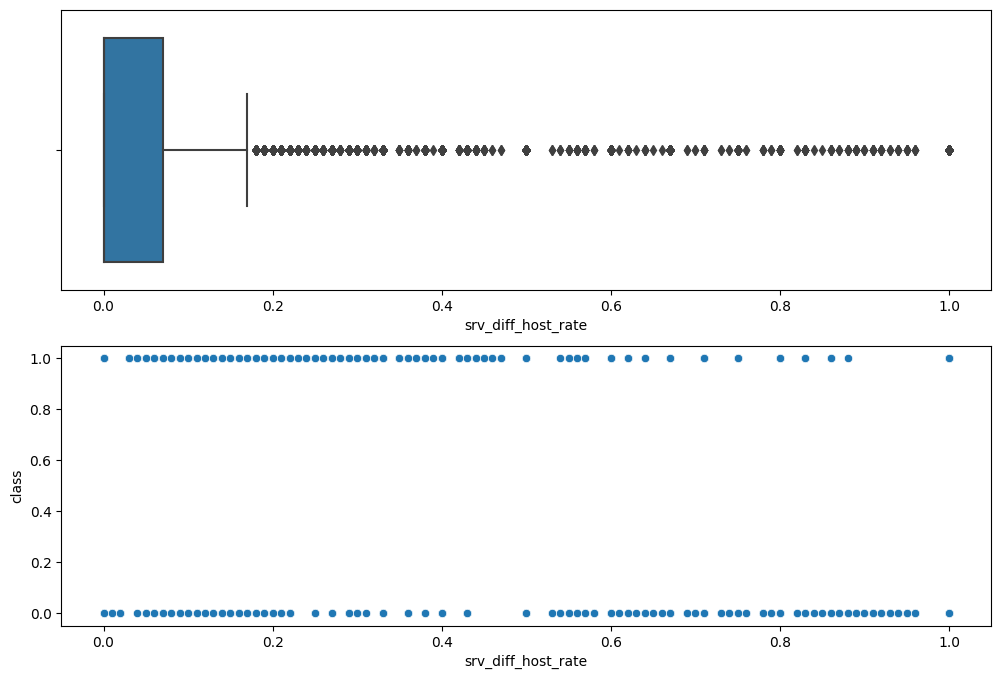

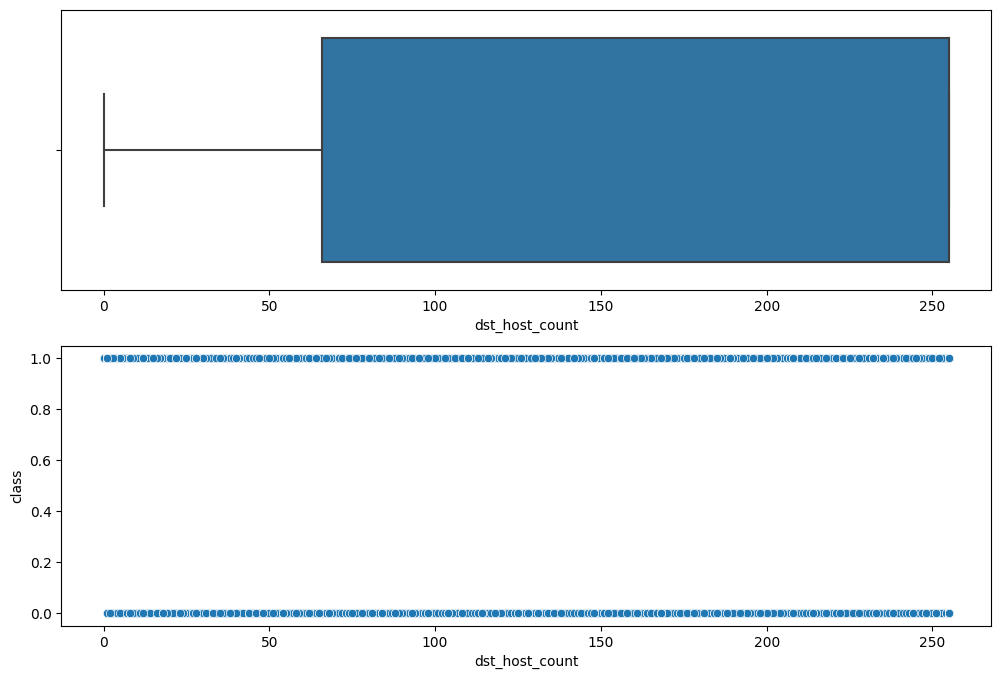

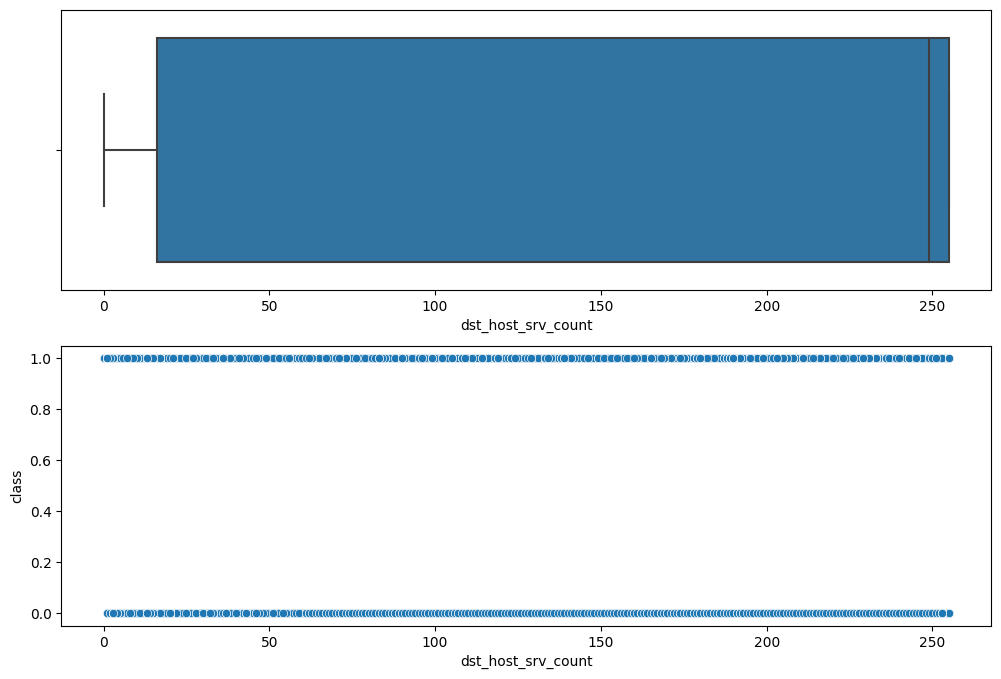

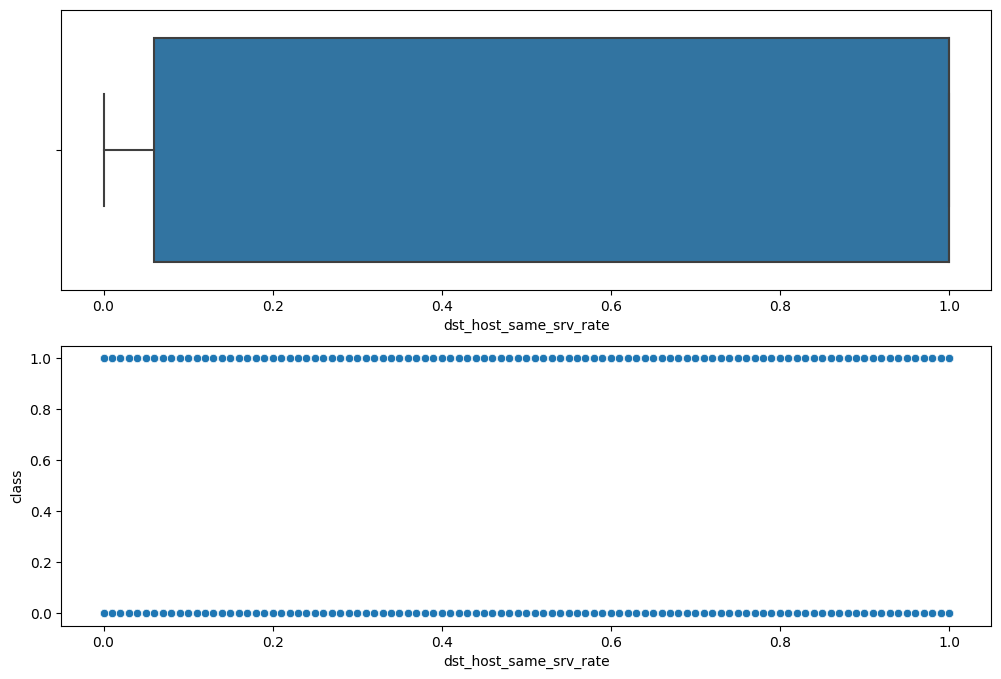

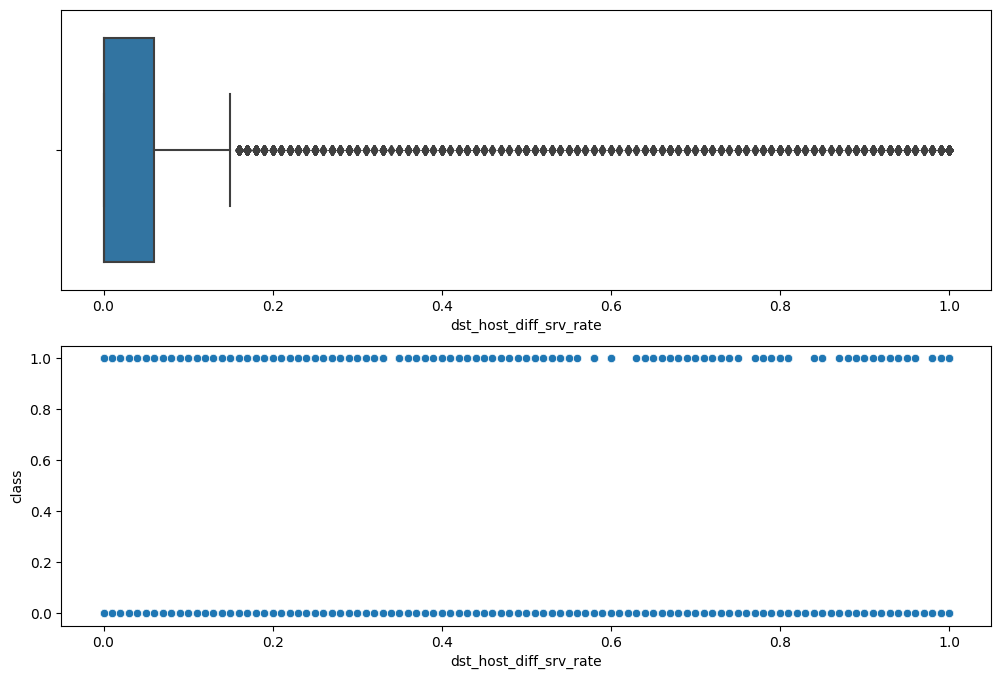

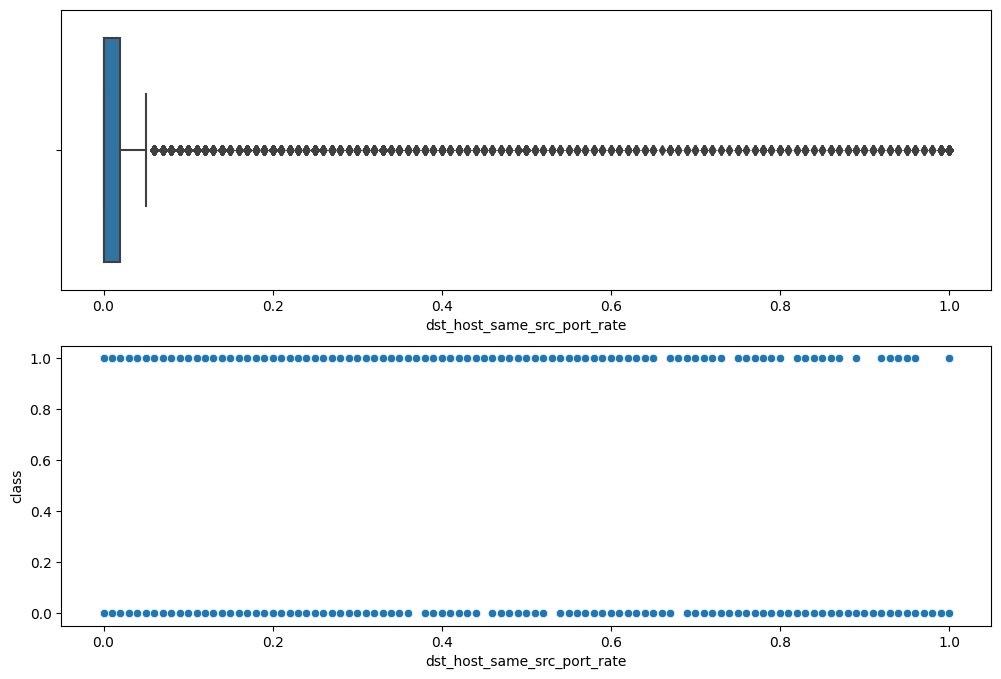

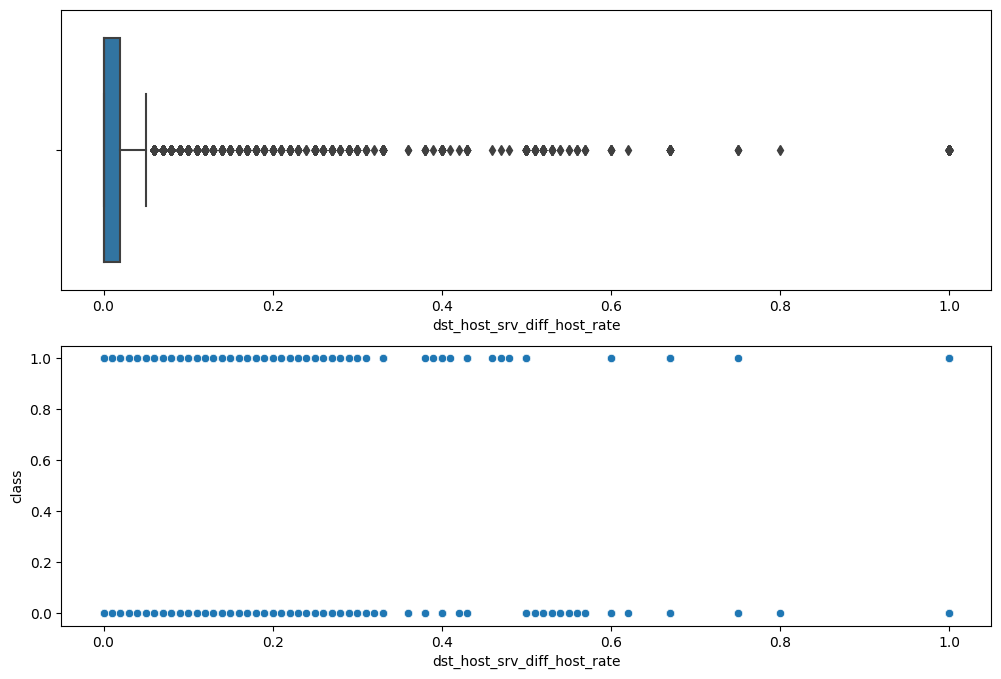

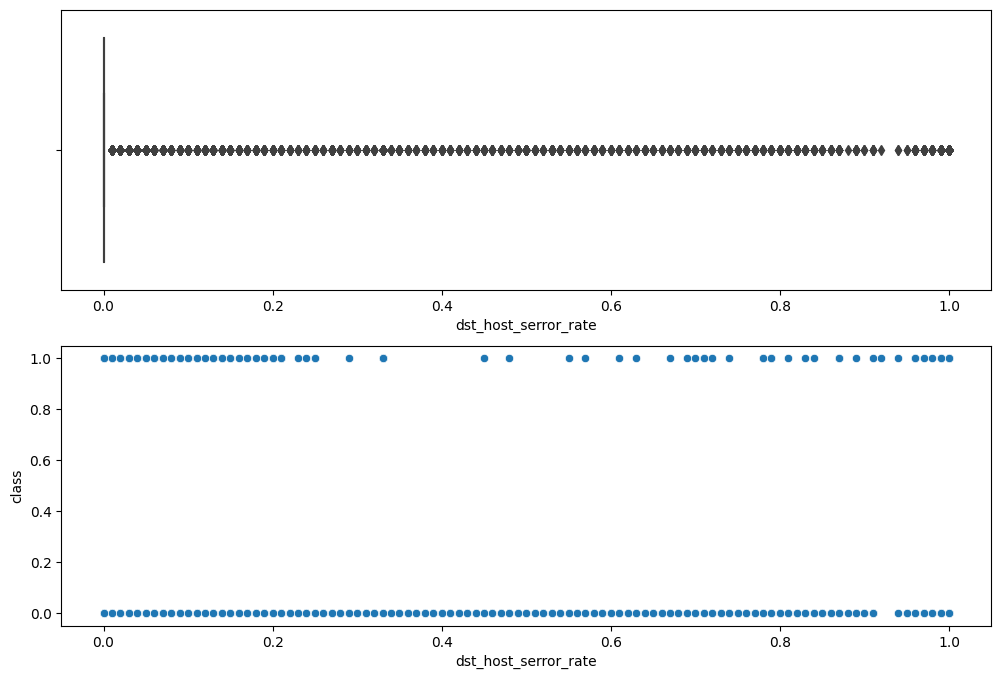

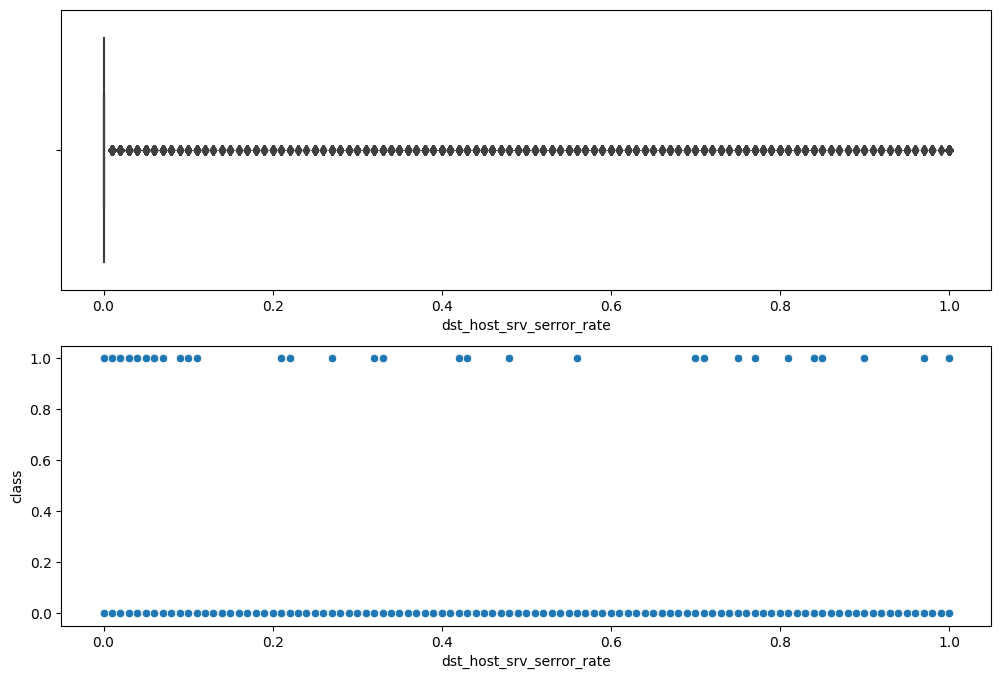

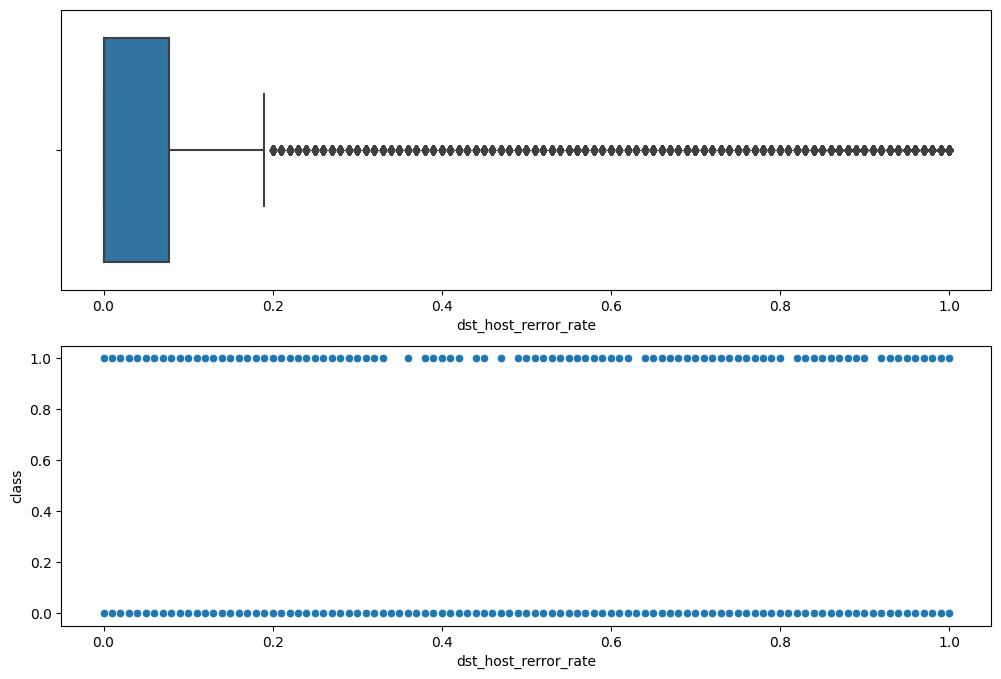

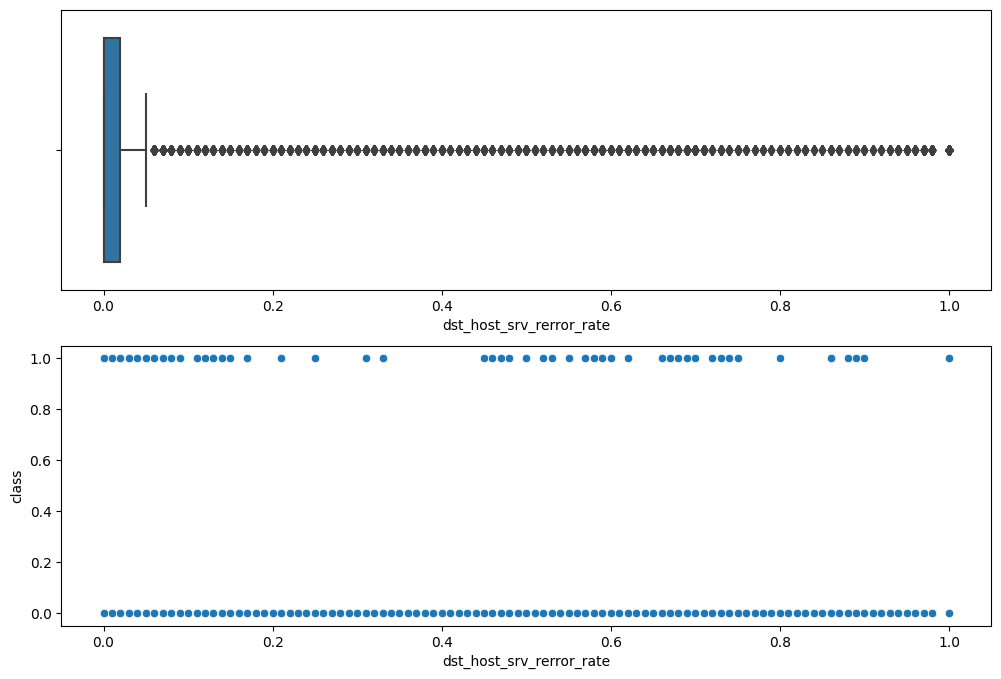

In [169]:
# for col in train:
#     if col != 'class' and is_numeric_dtype(train[col]):
#         fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#         g1 = sns.boxplot(x = train[col], ax=ax[0])
#         g2 = sns.scatterplot(data=train, x=train[col],y=train['class'], ax=ax[1])
#         plt.show()

C:\Users\rax\AppData\Local\Temp\ipykernel_13176\3426106910.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<AxesSubplot:>

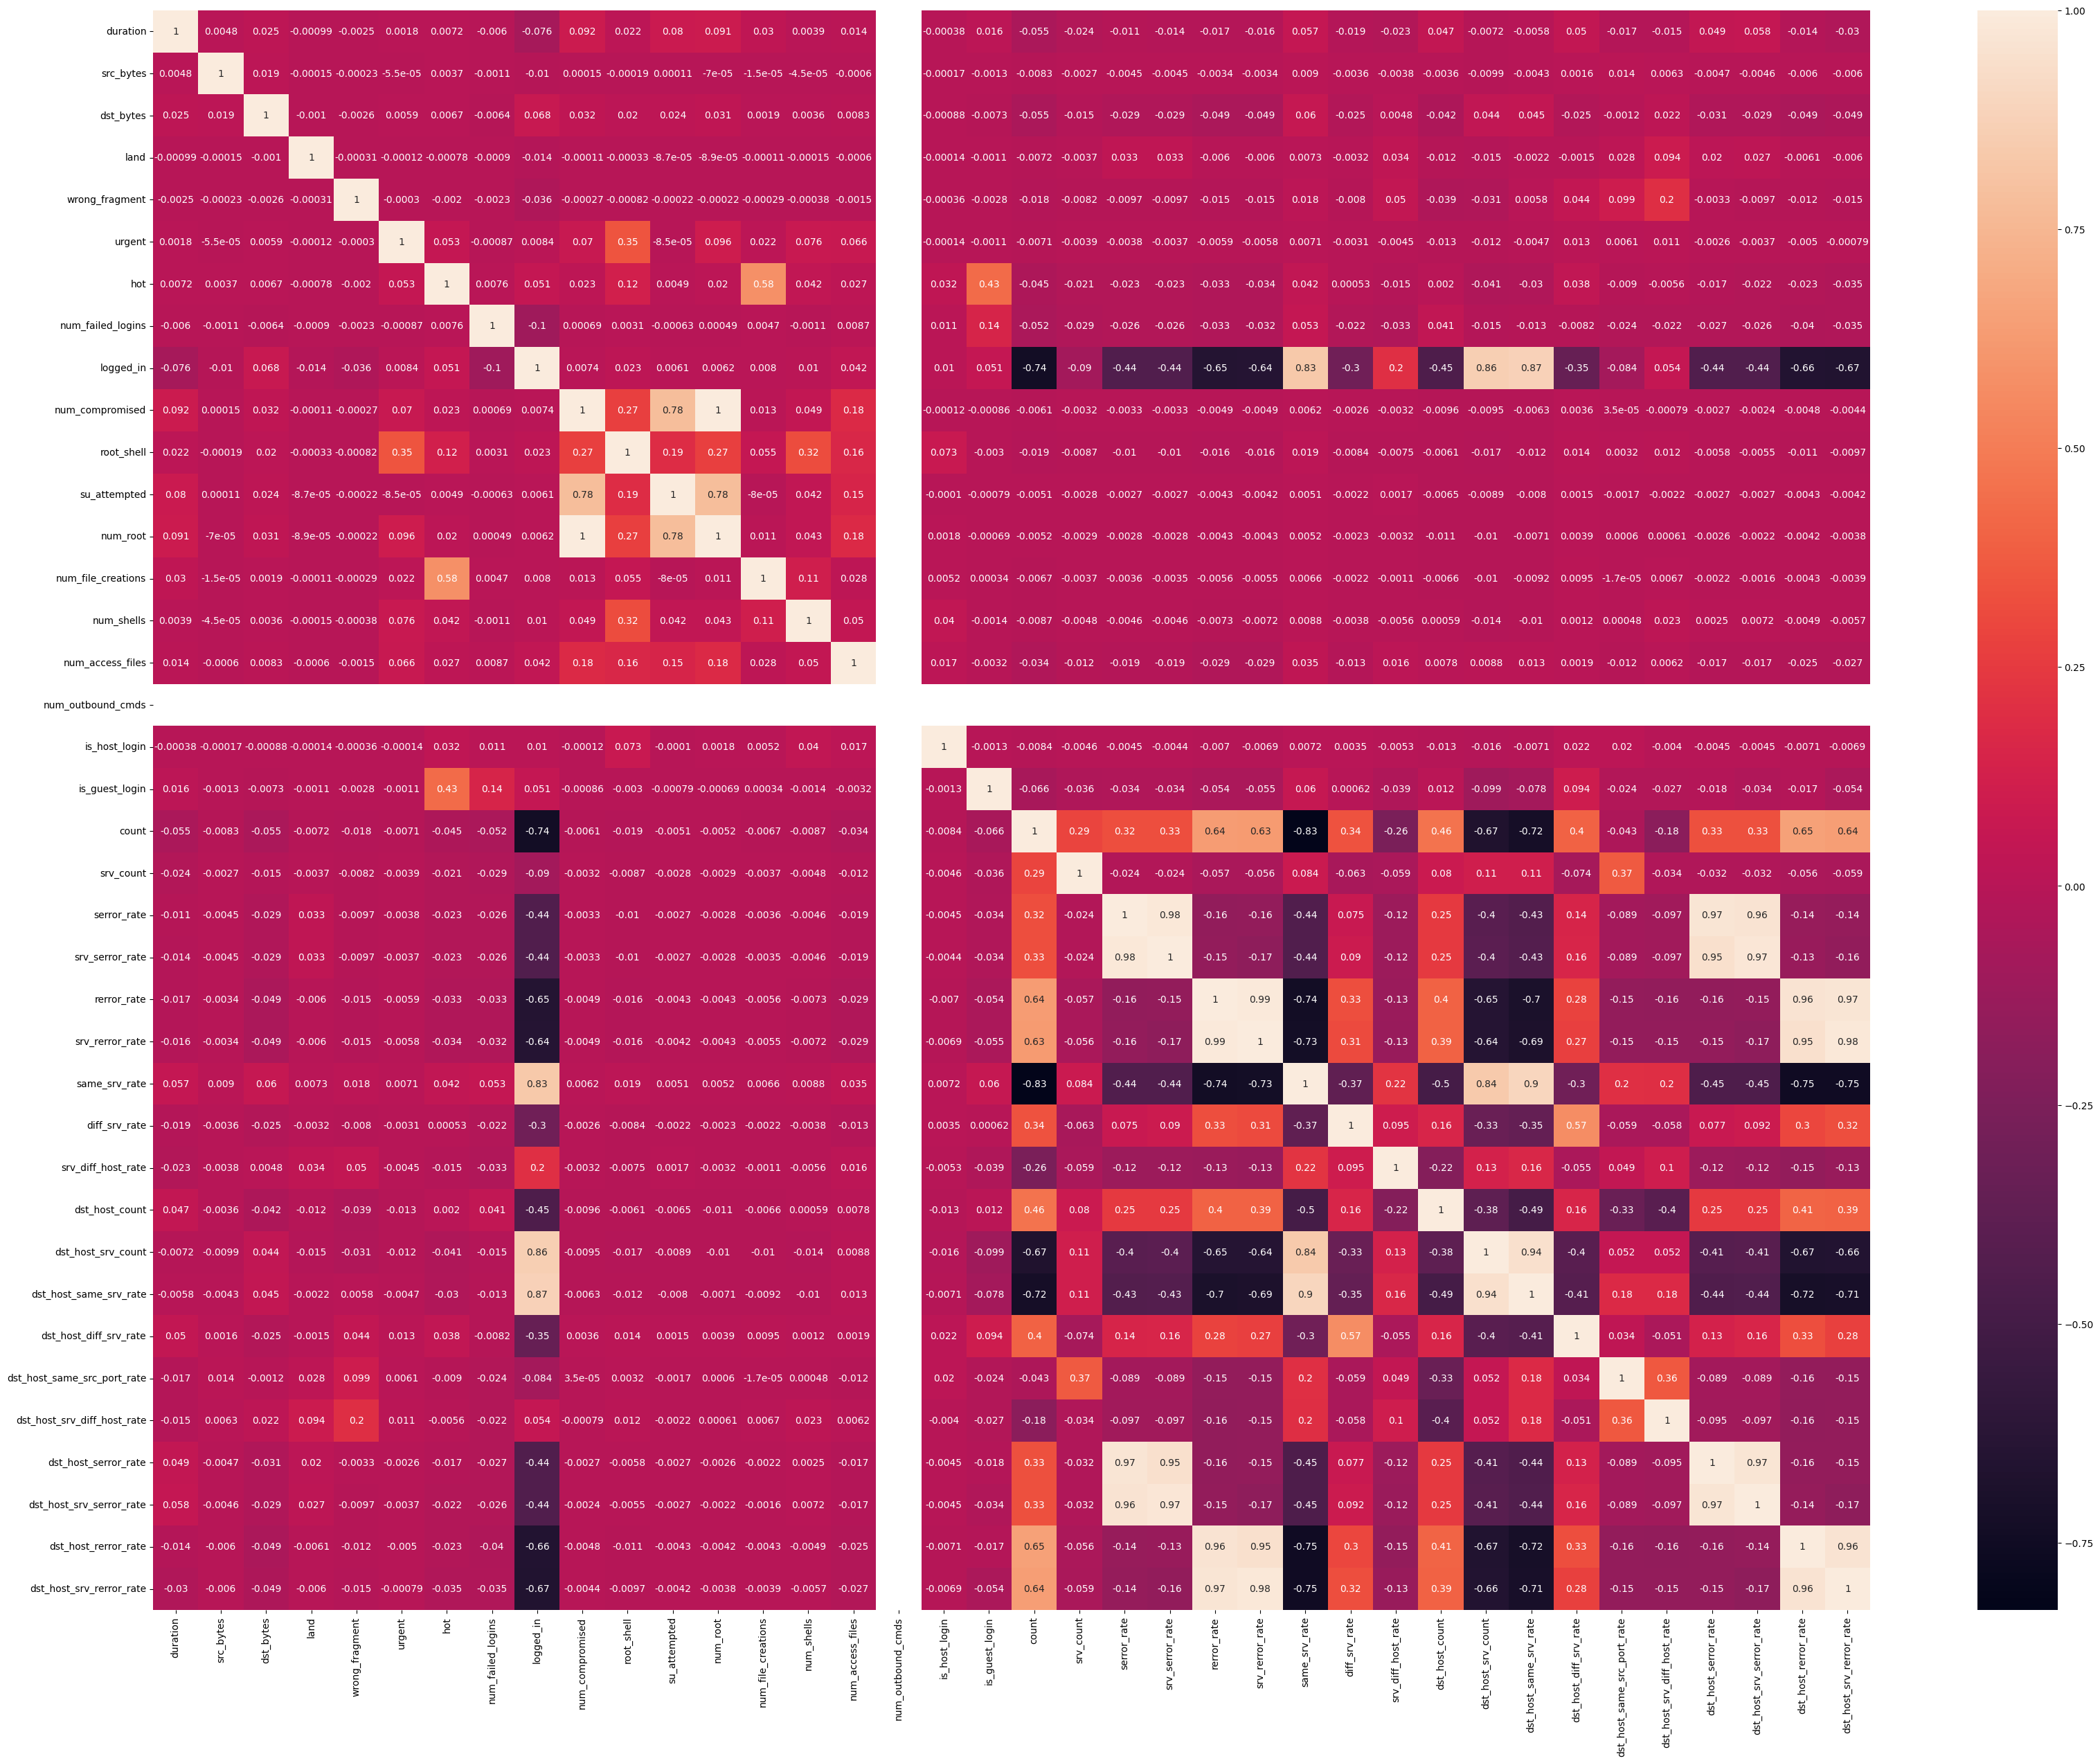

In [166]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

<AxesSubplot:xlabel='class', ylabel='count'>

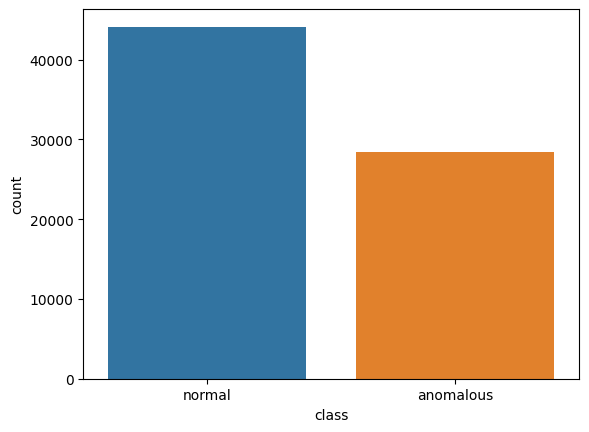

In [167]:
sns.countplot(x=train['class'])

### Label Encoding

In [168]:
def le(train):
    for col in train.columns:
        if train[col].dtype == 'object':
                label_encoder = LabelEncoder()
                train[col] = label_encoder.fit_transform(train[col])

le(train)
le(test)
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
9,0,1,21,9,223,185,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.00,1
11,0,1,21,9,230,260,0,0,0,0,...,255,1.00,0.00,0.33,0.07,0.33,0.0,0.00,0.00,1
14,1,1,48,9,3170,329,0,0,0,0,...,39,0.72,0.11,0.02,0.00,0.02,0.0,0.09,0.13,1
15,0,1,21,9,297,13787,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.00,1
16,0,1,21,9,291,3542,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.00,1
